<a href="https://colab.research.google.com/github/sudoice/Unit-1-Freeze-of-Gait-Detection-TinyML/blob/main/_DON'T_CHANGE_FoG_Detection_FINAL_with_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [ ]:
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/aiht/freeze-of-gait/dataset/"
dataset_zip = dataset_dir + "dataset_fog_release.zip"

!unzip -q "$dataset_zip"

Mounted at /content/drive


In [ ]:
features = ['Time', 'ankle-x', 'ankle-y', 'ankle-z',
            'thigh-x', 'thigh-y', 'thigh-z',
            'trunk-x', 'trunk-y', 'trunk-z', 'annotations']
len(os.listdir('dataset_fog_release/dataset'))

17

In [ ]:
!mkdir CSV

# Read data from .txt file into a dataframe, name the column names, convert into CSV file
for name in os.listdir('dataset_fog_release/dataset'):
    df = pd.read_csv('dataset_fog_release/dataset/' + name, header = None, sep=' ')

    df.columns = features
    df = df[df.annotations != 0]

    fname=name.split('.')[0];
    if(fname=="S04R01" or fname=="S10R01"):
      continue
    name = 'CSV/' + fname +'.csv'
    df.to_csv(name, index = None)  # Don't store the index column

In [ ]:
# import shutil

# shutil.rmtree("CSV")

Data Preprocessing

In [ ]:
os.makedirs("Combined", exist_ok=True)

processed_data = []

# windowing parameters
full_size = 128
overlap = 0.5
overlap_size = int(full_size * overlap / 2) # 64
entry_size = full_size - overlap_size  # 32

data_dir = 'CSV'

for name in os.listdir(data_dir):
    data = pd.read_csv(os.path.join(data_dir, name))

    required_columns = ['ankle-x', 'ankle-y', 'ankle-z',
                        'thigh-x', 'thigh-y', 'thigh-z',
                        'trunk-x', 'trunk-y', 'trunk-z', 'annotations']
    data = data[required_columns]

    # Sliding window approach
    for i in range(0, data.shape[0], entry_size):
        if data.shape[0] >= i + full_size:
            window = data.iloc[i:i + full_size]
            input_features = window.iloc[:, :-1].to_numpy()  # 128x9 array
            sub_classes = window['annotations'].to_list()
            most_common_class = max(set(sub_classes), key=sub_classes.count)  # Majority class label

            processed_data.append([input_features, most_common_class])

final_df = pd.DataFrame(processed_data, columns=['features', 'label'])

final_df.to_pickle("Combined/final_dataset.pkl")

print("Dataset creation complete. Stored in Combined/final_dataset.pkl")

Dataset creation complete. Stored in Combined/final_dataset.pkl


In [ ]:
final_df.iloc[:, 1] = np.where(final_df.iloc[:, 1] == 1, 0, 1) # 0: NO FREEZE , 1: FREEZE

In [ ]:
final_df.iloc[:, 1].value_counts()

,count
label,
0,7849
1,1157


In [ ]:
x=final_df["features"]
y=final_df["label"]

In [ ]:
x.shape

(9006,)

In [ ]:
x = np.stack(x.values)
x.shape

(9006, 128, 9)

In [ ]:
y.unique()

array([0, 1])

In [ ]:
y.shape

(9006,)

In [ ]:
trainx,testx,trainy,testy=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
trainx.shape

(7204, 128, 9)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize StandardScaler
# scaler = StandardScaler()

# # Flatten and fit
# trainx_ = trainx.reshape(-1, trainx.shape[-1])
# testx_ = testx.reshape(-1, testx.shape[-1])

# # Standardize (zero mean, unit variance)
# trainx = scaler.fit_transform(trainx_).reshape(-1, trainx.shape[1], trainx.shape[2])
# testx = scaler.transform(testx_).reshape(-1, testx.shape[1], testx.shape[2])

In [ ]:
class_labels = final_df['label'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=trainy)
class_weight_dict = dict(zip(class_labels, class_weights))
print(class_weight_dict)

{0: 0.5741153968759962, 1: 3.8731182795698924}


In [ ]:
trainy=np.array(trainy)  # trainy was originally a pd Series

In [ ]:
from sklearn.model_selection import KFold

def create_model(n_timesteps, n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(n_timesteps, n_features)),
        tf.keras.layers.Conv1D(32, kernel_size=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(16, kernel_size=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.GlobalAveragePooling1D(),  # to reduce the input size to next layers
        tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(), # overcome internal covariate shift
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'accuracy']
    )
    return model

def find_best_threshold(model, validx, validy):
    predictions = model.predict(validx)
    precisions, recalls, thresholds = precision_recall_curve(validy, predictions)
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-7)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

class BestWeightCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', mode='min', verbose=1):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if ((self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best)):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            if self.verbose:
                print('\nRestoring best weights')
            self.model.set_weights(self.best_weights)

def train_model(trainx, trainy, epochs=100, batch_size=32, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresholds = []
    histories=[]

    for train_idx, val_idx in kfold.split(trainx):
        x_train, x_val = trainx[train_idx], trainx[val_idx]
        y_train, y_val = trainy[train_idx], trainy[val_idx]

        model = create_model(x_train.shape[1], x_train.shape[2])
        best_weights_callback = BestWeightCallback(monitor='val_loss', mode='min')
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

        history=model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            callbacks=[best_weights_callback, reduce_lr, early_stopping],
            verbose=1
        )

        best_threshold = find_best_threshold(model, x_val, y_val)
        best_thresholds.append(best_threshold)
        histories.append(history)

    avg_threshold = np.mean(best_thresholds)
    return model, histories, avg_threshold

def predict_with_threshold(model, x_test, threshold=0.6):
    predictions = model.predict(x_test)
    return (predictions > threshold).astype(np.int32)

In [ ]:
model, histories, best_threshold = train_model(trainx, trainy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5469 - loss: 0.8308 - precision: 0.1781 - recall: 0.7128
Epoch 0: val_loss improved from inf to 0.4761
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5486 - loss: 0.8275 - precision: 0.1791 - recall: 0.7146 - val_accuracy: 0.8244 - val_loss: 0.4761 - val_precision: 0.1932 - val_recall: 0.0854 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7049 - loss: 0.5921 - precision: 0.2879 - recall: 0.8362 - val_accuracy: 0.8210 - val_loss: 0.4832 - val_precision: 0.4264 - val_recall: 0.8593 - learning_rate: 0.0010
Epoch 3/100
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7737 - loss: 0.5068 - precision: 0.3401 - recall: 0.8465
Epoch 2: val_loss improved from 0.4761 to 0.4131
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7737 - loss: 0.5068 - precision: 0.3402 - recall: 0.8465 - val_accuracy: 0.8390 - val_loss: 0.4131 - val_precision: 0.4550 - val_recall: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6419 - loss: 0.8209 - precision: 0.1928 - recall: 0.5603
Epoch 0: val_loss improved from inf to 0.5237
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6421 - loss: 0.8194 - precision: 0.1935 - recall: 0.5629 - val_accuracy: 0.8723 - val_loss: 0.5237 - val_precision: 0.3934 - val_recall: 0.1404 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7171 - loss: 0.5908 - precision: 0.3085 - recall: 0.8816 - val_accuracy: 0.7550 - val_loss: 0.5733 - val_precision: 0.3202 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7842 - loss: 0.5142 - precision: 0.3514 - recall: 0.8173 - val_accuracy: 0.7287 - val_loss: 0.6190 - val_precision: 0.2993 - val_recall: 0.9591 - learning_rate: 0.0010
Epoch 4/100
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8031 - loss: 0.4758 - precision: 0.3802 - recall: 0.8577
Epoch 3: val_loss im

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4218 - loss: 0.8047 - precision: 0.1649 - recall: 0.8341
Epoch 0: val_loss improved from inf to 0.5524
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4230 - loss: 0.8035 - precision: 0.1652 - recall: 0.8345 - val_accuracy: 0.8688 - val_loss: 0.5524 - val_precision: 0.5132 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/100
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7028 - loss: 0.5802 - precision: 0.2746 - recall: 0.8429
Epoch 1: val_loss improved from 0.5524 to 0.4349
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7032 - loss: 0.5799 - precision: 0.2751 - recall: 0.8429 - val_accuracy: 0.8487 - val_loss: 0.4349 - val_precision: 0.4663 - val_recall: 0.8557 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7700 - loss: 0.4854 - precision: 0.3289 - recall: 0.8738 - val_accuracy: 0.7724 - val_loss: 0.4682 - val_precision: 0.3665 - val_recall: 0.9485 - learn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5107 - loss: 0.8153 - precision: 0.1883 - recall: 0.8120
Epoch 0: val_loss improved from inf to 0.6027
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5116 - loss: 0.8138 - precision: 0.1886 - recall: 0.8123 - val_accuracy: 0.7745 - val_loss: 0.6027 - val_precision: 0.3107 - val_recall: 0.6611 - learning_rate: 0.0010
Epoch 2/100
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6954 - loss: 0.5915 - precision: 0.2828 - recall: 0.8686
Epoch 1: val_loss improved from 0.6027 to 0.4814
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6957 - loss: 0.5910 - precision: 0.2830 - recall: 0.8684 - val_accuracy: 0.8008 - val_loss: 0.4814 - val_precision: 0.3723 - val_recall: 0.8667 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7621 - loss: 0.5032 - precision: 0.3366 - recall: 0.8687 - val_accuracy: 0.7405 - val_loss: 0.5090 - val_precision: 0.3149 - val_recall: 0.9167 - learn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6184 - loss: 0.8090 - precision: 0.2019 - recall: 0.6552
Epoch 0: val_loss improved from inf to 0.4945
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6192 - loss: 0.8062 - precision: 0.2028 - recall: 0.6580 - val_accuracy: 0.8201 - val_loss: 0.4945 - val_precision: 0.3522 - val_recall: 0.4677 - learning_rate: 0.0010
Epoch 2/100
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7023 - loss: 0.6075 - precision: 0.2829 - recall: 0.8212
Epoch 1: val_loss improved from 0.4945 to 0.4674
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7027 - loss: 0.6068 - precision: 0.2833 - recall: 0.8218 - val_accuracy: 0.8424 - val_loss: 0.4674 - val_precision: 0.4395 - val_recall: 0.8011 - learning_rate: 0.0010
Epoch 3/100
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7579 - loss: 0.5418 - precision: 0.3278 - recall: 0.8301
Epoch 2: val_loss improved from 0.4674 to 0.4063
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - a

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_16               │ (None, 128, 9)              │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 128, 32)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 128, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 64, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 64, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 32, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,797 (34.37 KB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 146 (584.00 B)

 Optimizer params: 5,768 (22.54 KB)

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.title('Training and Validation ' + metric)
    plt.show()

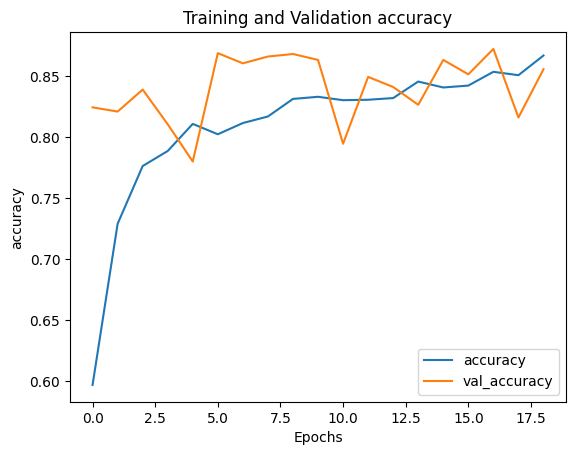

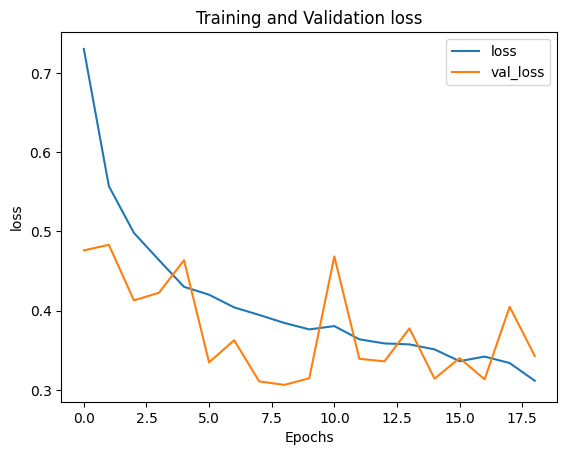

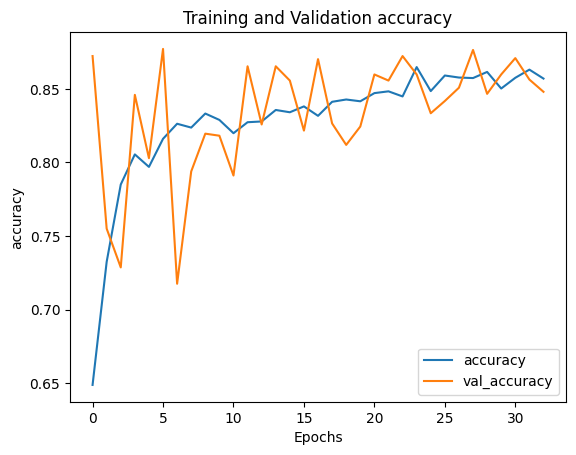

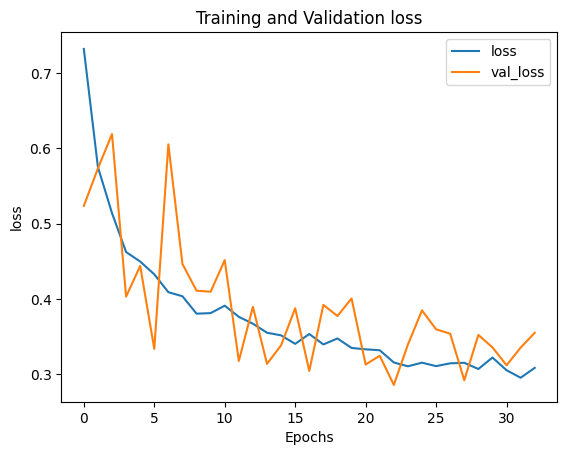

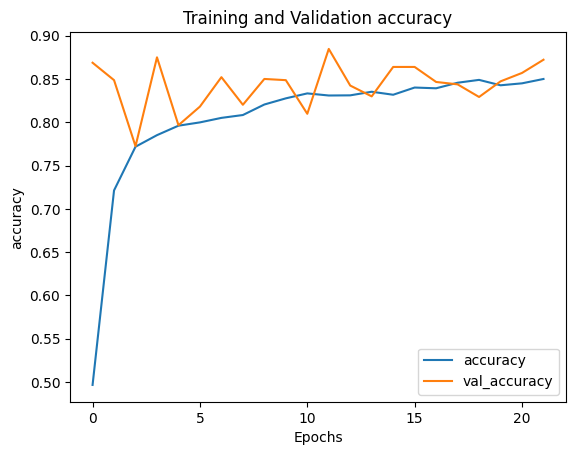

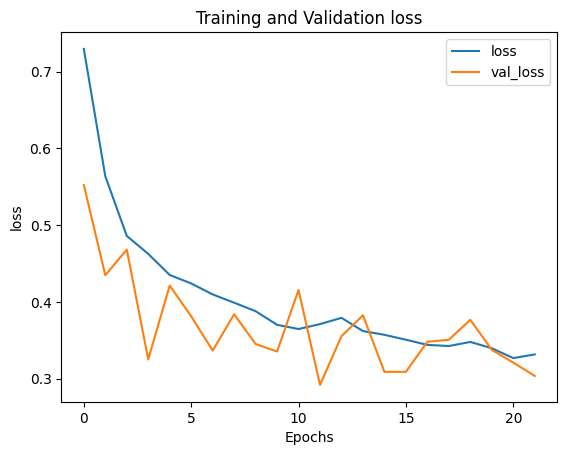

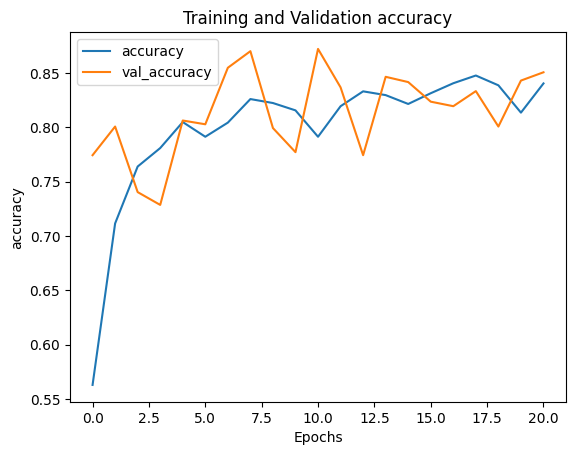

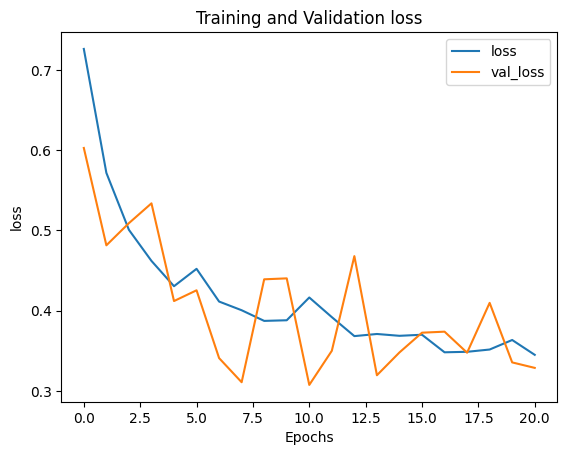

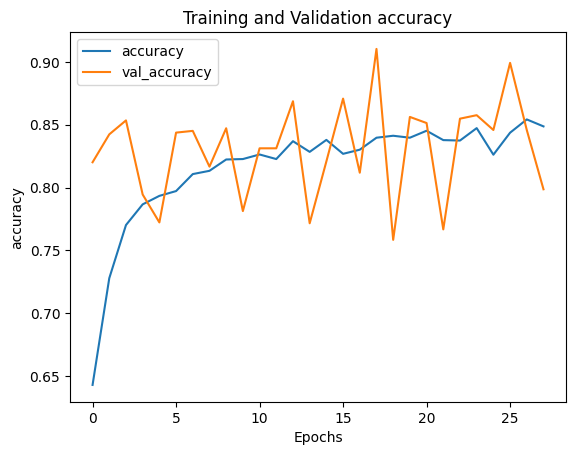

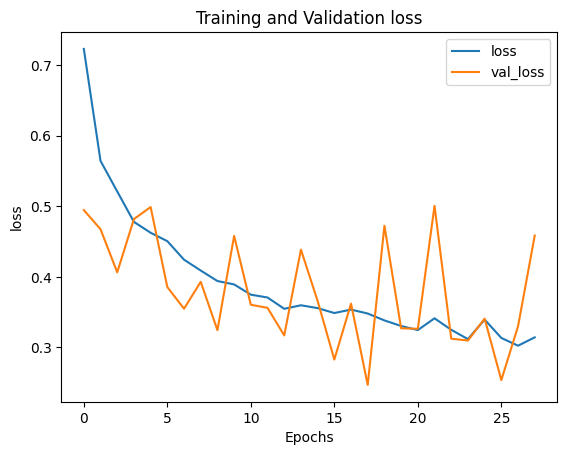

In [ ]:
for history in histories:
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

In [ ]:
y_pred = model.predict(testx)

# tryin different thresholds
thresholds = [best_threshold,]

for threshold in thresholds:
    print(f"\nResults with threshold {threshold}:")
    y_pred_binary = (y_pred > threshold).astype(int)

    print("\nClassification Report:")
    print(classification_report(testy, y_pred_binary))

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Results with threshold 0.6524919867515564:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1575
           1       0.71      0.73      0.72       227

    accuracy                           0.93      1802
   macro avg       0.84      0.84      0.84      1802
weighted avg       0.93      0.93      0.93      1802



In [ ]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.where(y_pred<best_threshold,0,1)
  y_test = testy

  # Confusion matrix
  print('Confusion Matrix')

  cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix
Accuracy for Test Data =  92.84128745837957


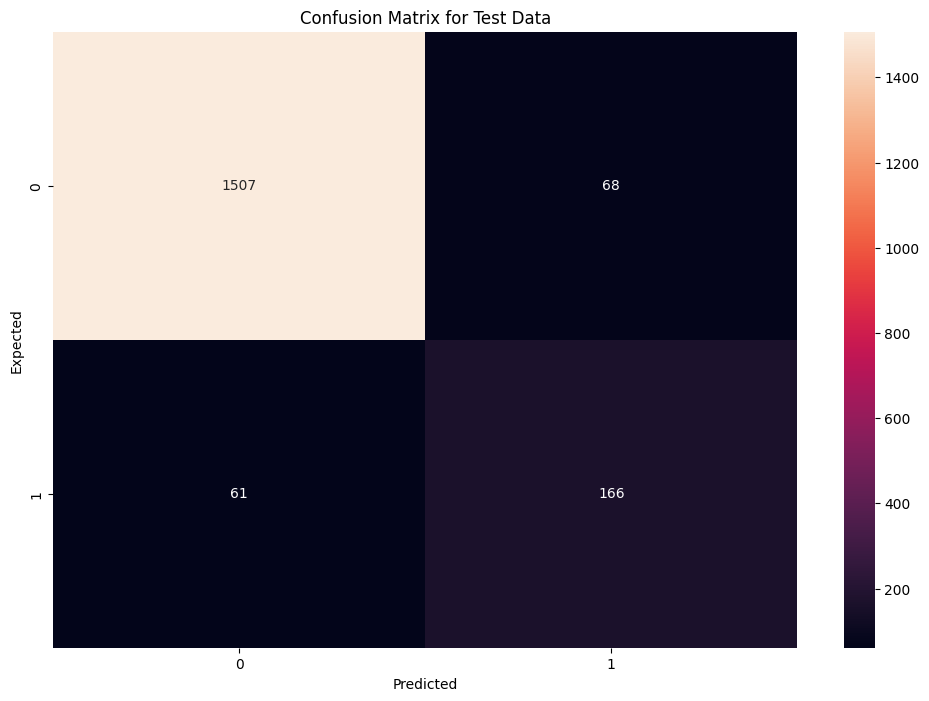


Precision vs Recall Curve


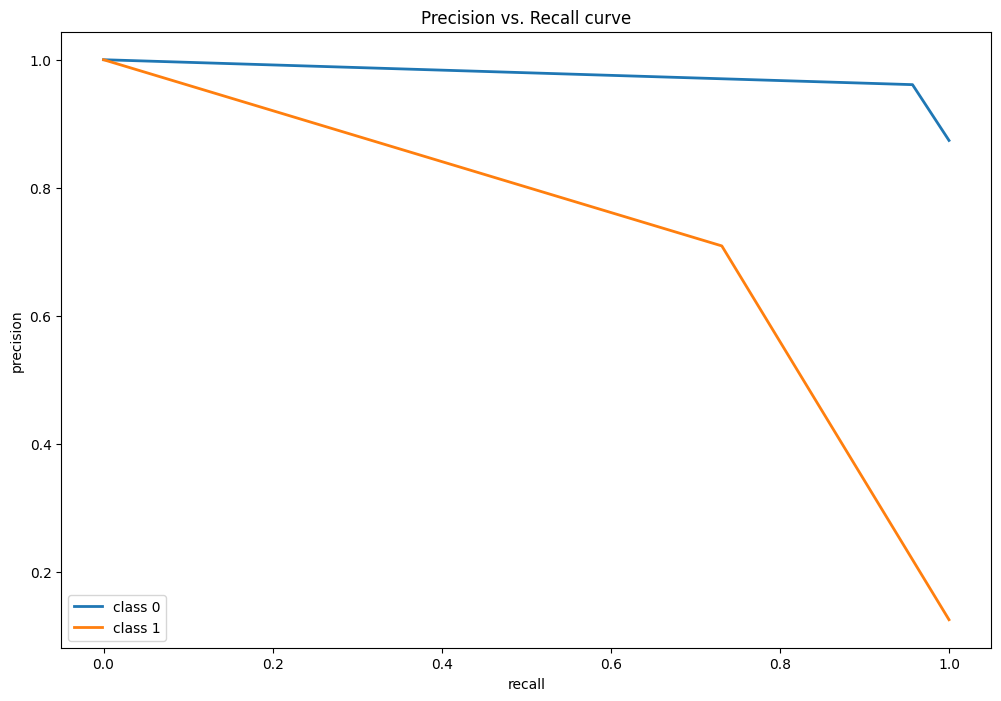


ROC Curve
ROC AUC score: 0.8440514649325221


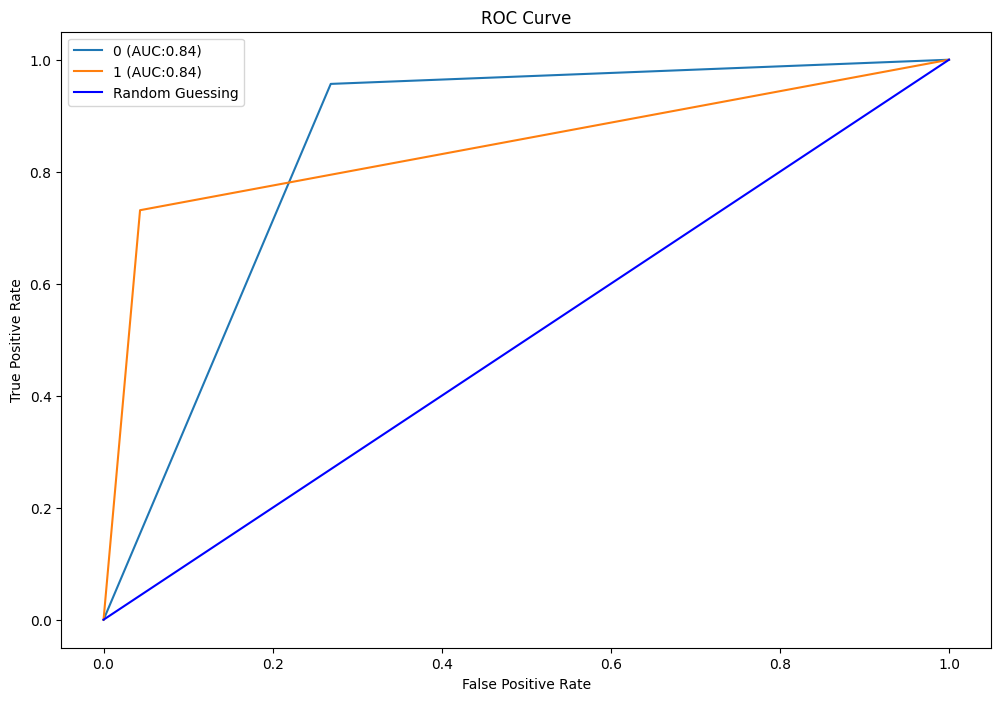

In [ ]:
model_evaluate(model, [0,1], testx, testy)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_16               │ (None, 128, 9)              │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 128, 32)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 128, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 64, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 64, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 32, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,797 (34.37 KB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 146 (584.00 B)

 Optimizer params: 5,768 (22.54 KB)

In [ ]:
model.save("/content/drive/MyDrive/aiht/freeze-of-gait/saved-model/FOG_Model_PROPER.keras")
print("FOG_Model saved Successfully!")

FOG_Model saved Successfully!


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/aiht/freeze-of-gait/saved-model/FOG_Model_PROPER.keras")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_16               │ (None, 128, 9)              │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 128, 32)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 128, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 64, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 64, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 32, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,797 (34.37 KB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 146 (584.00 B)

 Optimizer params: 5,768 (22.54 KB)

In [ ]:
# helps in calibration during quantization.
def representative_data_gen():
    for i in range(100):
        yield [trainx[i:i+1].astype(np.float32)]

model = tf.keras.models.load_model("/content/drive/MyDrive/aiht/freeze-of-gait/saved-model/FOG_Model_PROPER.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply default optimizations for quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set the representative dataset for calibration
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Integer Quantization with Float I/O
# converter.inference_input_type = tf.float32  # Input will be int32
# converter.inference_output_type = tf.float32 # Output will be int32

try:
    tflite_model = converter.convert()
    print("TFLite model converted to int8 successfully!")
except Exception as e:
    print("Error during conversion:", str(e))

# Save the quantized model to a file
tflite_model_path = "/content/drive/MyDrive/aiht/freeze-of-gait/saved-model/quantized_FOG_Model_PROPER.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Quantized int8 model saved successfully at: {tflite_model_path}")

Saved artifact at '/tmp/tmplrgk7z8l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 9), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140638117841232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117843152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117843920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117851024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117843536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117843344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117853904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117853520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117851408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117844112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140638117844688: T

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite model converted to int8 successfully!
Quantized int8 model saved successfully at: /content/drive/MyDrive/aiht/freeze-of-gait/saved-model/quantized_FOG_Model_PROPER.tflite


In [ ]:
with open('/content/drive/MyDrive/aiht/freeze-of-gait/saved-model/cmodel_PROPER.h', 'w') as f:
    f.write("const unsigned char model_data[] = {")
    f.write(",".join([hex(b) for b in tflite_model]))   # converts each byte of the TensorFlow Lite model (tflite_model) into its hexadecimal representation.
    # These hexadecimal strings are then joined together with commas.
    f.write("};")
    f.write(f"\nunsigned int model_data_len = {len(tflite_model)};")